In [1]:
import argparse
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [43]:

def collect_image_paths(folder_path, valid_exts=('.png', '.jpg', '.jpeg', '.bmp', '.tiff'), suffix=None):
    """
    Return a sorted list of Paths to images in the given folder,
    matching any of the valid_exts.
    """
    folder = Path(folder_path)
    if not folder.is_dir():
        raise NotADirectoryError(f"'{folder}' is not a valid directory.")

    image_files = sorted([
        f for f in folder.iterdir()
        if f.is_file() and f.suffix.lower() in valid_exts
    ])
    # filter by suffix if provided
    if suffix:
        # remove files that do not end with the suffix
        image_files = [f for f in image_files if f.name.endswith(suffix)]
    return image_files

data_folder = "../../data/processed/leonard_dataset/"#dataset_train_val_test_split/train/" #"../../data/raw/labelbox_output_mbs_0123/"
masks_folder = data_folder + "masks"
imgs_folder = data_folder + "imgs"

images = collect_image_paths(imgs_folder)
masks = collect_image_paths(masks_folder, suffix="_bolus.png")
print(len(masks))
print(len(images))

11330
11330


In [35]:
# add "_bolus.png" to the end of the image file name from masks and save it in the same folder
for mask in masks:
    # split name by first . and add "_bolus.png" to the end
    mask.rename(mask.with_name(mask.name.split(".")[0] + "_bolus.png"))


In [11]:

def compute_resolution_stats(image_paths):
    """
    Given a list of grayscale image paths, compute min, max, mean (height, width).
    Returns a dict with keys: 'min_h', 'max_h', 'mean_h', 'min_w', 'max_w', 'mean_w'.
    """
    heights = []
    widths = []
    resolutions = []

    for p in image_paths:
        with Image.open(p) as img:
            arr = np.array(img.convert('L'), dtype=np.uint8)
        h, w = arr.shape
        heights.append(h)
        widths.append(w)
        resolutions.append(f"{w}x{h}")
    # print resolution value counts
    print("Resolution value counts: ")
    print(pd.Series(resolutions).value_counts())

    print("Stats: ")
    print(f" Height => min={np.min(heights)}, max={np.max(heights)}, mean={float(np.mean(heights)):.2f}")
    print(f" Width  => min={np.min(widths)}, max={np.max(widths)}, mean={float(np.mean(widths)):.2f}")


print("Masks: ")
compute_resolution_stats(masks)
print("\n\nImages: ")
compute_resolution_stats(images)

Masks: 


KeyboardInterrupt: 

In [44]:

def compute_histogram(image_paths):
    """
    Given a list of grayscale image paths, compute a combined histogram of pixel
    intensities [0..255] across all images. Returns a 256-element NumPy array.
    """
    combined_hist = np.zeros(256, dtype=np.int64)
    count = 0
    for p in image_paths:
        count += 1
        with Image.open(p) as img:
            arr = np.array(img.convert('L'), dtype=np.uint8)
        img_hist, _ = np.histogram(arr, bins=256, range=(0, 256))
        # check if the image has pixel values in [1..254]
        if np.any(img_hist[1:255] > 0):
            print(f"Image with pixel values in [1..254]: {p}")
            print(f"path: {p}")
            '''
            rgb = color_code_image(arr)

            # Side-by-side figure
            fig, axs = plt.subplots(1, 2, figsize=(12,6))
            axs[0].imshow(arr, cmap='gray', vmin=0, vmax=255)
            axs[0].set_title(f"Original grayscale\n{p.name}")
            axs[0].axis('off')

            axs[1].imshow(rgb)
            axs[1].set_title("Color-coded (0=black, 1=white, else=red)")
            axs[1].axis('off')
            #print which pixel values are in [1..254]
            print(f"Pixel values in [1..254]: {np.where(img_hist[1:255] > 0)}")
            '''
        combined_hist += img_hist

    return combined_hist


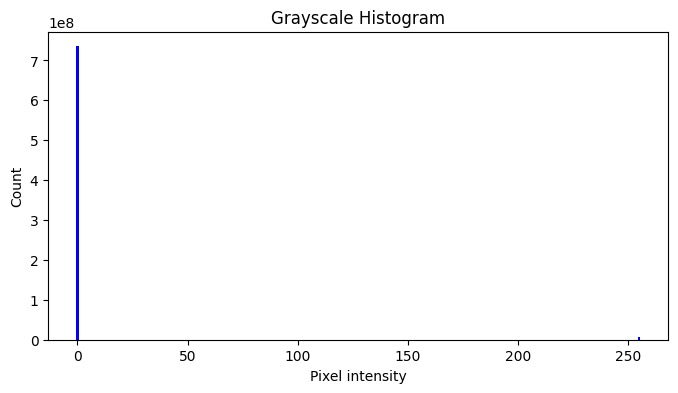

In [45]:

combined_hist = compute_histogram(masks)
plt.figure(figsize=(8,4))
plt.bar(range(256), combined_hist, width=1.0, color='blue')
plt.title("Grayscale Histogram")
plt.xlabel('Pixel intensity')
plt.ylabel('Count')
plt.show()

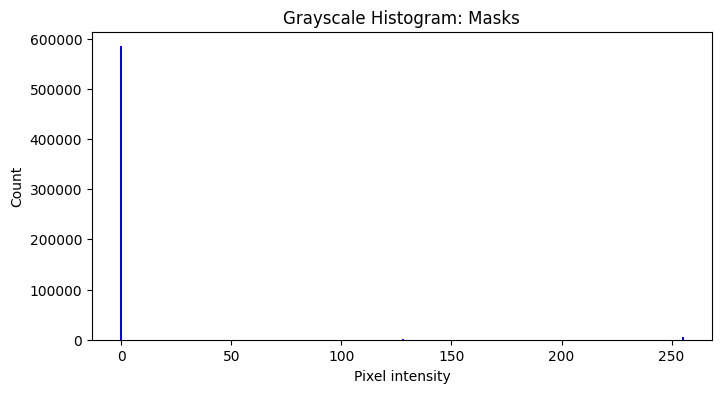

Images with pixel values in [1..254]: 3 / 8366 (0.04%)
Image with pixel values in [1..254]: 64
Image with pixel values in [1..254]: 128
Image with pixel values in [1..254]: 191


In [15]:
combined_hist = compute_histogram(masks)
# exlude 0 and 255
#combined_hist[0] = 0
#combined_hist[255] = 0
plt.figure(figsize=(8,4))
plt.bar(range(256), combined_hist, width=1.0, color='blue')
plt.title("Grayscale Histogram: Masks")
plt.xlabel('Pixel intensity')
plt.ylabel('Count')
plt.show()

# print how many images have pixel values in [1..254]
num_images = len(masks)
num_nonzero_images = np.count_nonzero(combined_hist[1:255])
print(f"Images with pixel values in [1..254]: {num_nonzero_images} / {num_images} ({num_nonzero_images/num_images:.2%})")

# get id of image with pixels in [1..254]
for i, hist in enumerate(combined_hist):
    if hist > 0 and i != 0 and i != 255:
        print(f"Image with pixel values in [1..254]: {i}")




In [26]:
def find_first_image_in_range(image_paths, low=100, high=200):
    """
    Returns the tuple (Path, np.array) for the first image that contains any pixel
    in [low..high], or None if none found.
    """
    for p in image_paths:
        with Image.open(p) as img:
            arr = np.array(img.convert('L'), dtype=np.uint8)
        if ((arr >= low) & (arr <= high)).any():
            return p, arr
    return None


def color_code_image(arr):
    """
    Given a 2D array of grayscale intensities [0..255],
    produce a color-coded 3D array (H,W,3) as follows:
      - 0 => black (0,0,0)
      - 1 => white (255,255,255)
      - else => red, with the original intensity as the red channel (val,0,0)
    """
    h, w = arr.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    zero_mask = (arr == 0)
    one_mask  = (arr == 1)
    else_mask = (~zero_mask & ~one_mask)

    # 0 => black
    rgb[zero_mask] = (0,0,0)
    # 1 => white
    rgb[one_mask]  = (255,255,255)
    # else => red with original intensity in red channel
    rgb[else_mask, 0] = arr[else_mask]

    return rgb


def plot_histogram_excluding_0_and_255(combined_hist, num_images, title="Histogram"):
    """
    Plot a bar chart of combined_hist for bins 1..254, excluding bins at 0 and 255.
    """
    plt.figure(figsize=(8,4))
    plt.bar(range(1, 255), combined_hist[1:255], width=1.0, color='blue')
    plt.title(f"{title} (excluding bins at 0 & 255)\n({num_images} images)")
    plt.xlabel('Pixel intensity (1..254)')
    plt.ylabel('Count')
    plt.tight_layout()




In [ ]:
def analyze_and_visualize(folder_path, title="Analysis"):
    """
    1) Collect valid image files from `folder_path`.
    2) Compute resolution stats and print them.
    3) Build a combined histogram, then plot it but exclude bins 0 & 255 for visibility.
    4) Find the first image that has any pixel in [100..200].
       Show it side-by-side with a color-coded version (0=black,1=white, else=red).
    """
    # 1) Gather image files
    image_files = collect_image_paths(folder_path)
    if not image_files:
        print(f"[Warning] No valid images found in '{folder_path}'.")
        return

    print(f"=== {title} ===")
    print(f"Found {len(image_files)} images in '{folder_path}'.\n")

    # 2) Resolution stats
    stats = compute_resolution_stats(image_files)
    print("Resolution stats:")
    print(f"  Height => min={stats['min_h']}, max={stats['max_h']}, mean={stats['mean_h']:.2f}")
    print(f"  Width  => min={stats['min_w']}, max={stats['max_w']}, mean={stats['mean_w']:.2f}")
    print()

    # 3) Combined histogram
    combined_hist = compute_histogram(image_files)
    plot_histogram_excluding_0_and_255(combined_hist, len(image_files), title=f"{title}: Grayscale Histogram")

    # 4) Show first image with [100..200] side-by-side
    first = find_first_image_in_range(image_files, low=100, high=200)
    if first:
        p, arr = first
        print(f"First image with pixels in [100..200]: {p}")

        rgb = color_code_image(arr)

        # Side-by-side figure
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(arr, cmap='gray', vmin=0, vmax=255)
        axs[0].set_title(f"Original grayscale\n{p.name}")
        axs[0].axis('off')

        axs[1].imshow(rgb)
        axs[1].set_title("Color-coded (0=black, 1=white, else=red)")
        axs[1].axis('off')

        plt.tight_layout()
    else:
        print("No image has pixel values in [100..200].")

    plt.show()